In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time

from pyfigtree import figtree
from scipy.optimize import root
from scipy.integrate import odeint

epsilon = 1e-5

%matplotlib inline

In [2]:
#Calculate the iteraction using direct methods
def direct_evaluation(S,T,weights,delta):
    checkPot = []
    for target in T:
        # for each source, add to potential at current target
        diff = target-S
        norm = np.linalg.norm(diff, axis=1)
        up = (norm / delta)**2
        potential = np.exp(-up)*weights
        
        cum_potential = np.sum(potential)
        checkPot.append(cum_potential)
    return np.array(checkPot)

# Form Evolution Equations
## Direct Functions

In [3]:
def direct_position(X,alpha,delta):
    X_x = direct_evaluation(X,X,alpha[:,0], delta)
    X_y = direct_evaluation(X,X,alpha[:,1], delta)
    X_z = direct_evaluation(X,X,alpha[:,2], delta) 
    return np.dstack([X_x,X_y, X_z])[0]

In [4]:
def direct_momentum(X,alpha,delta):
    ax = alpha[:,0]
    ay = alpha[:,1]
    az = alpha[:,2]
    
    first_weights = np.dstack([ax * X[:,0], ax * X[:,1], ax * X[:,2]])[0]
    second_weights = np.dstack([ay * X[:,0], ay * X[:,1], ay * X[:,2]])[0]
    third_weights = np.dstack([az * X[:,0], az * X[:,1], az * X[:,2]])[0]
    
    first_sum_x = direct_evaluation(X,X,first_weights[:,0],delta)
    first_sum_y = direct_evaluation(X,X,first_weights[:,1],delta)
    first_sum_z = direct_evaluation(X,X,first_weights[:,2],delta)
    
    
    second_sum_x = direct_evaluation(X,X,second_weights[:,0],delta)
    second_sum_y = direct_evaluation(X,X,second_weights[:,1],delta)
    second_sum_z = direct_evaluation(X,X,second_weights[:,2],delta)
    
    
    third_sum_x = direct_evaluation(X,X,third_weights[:,0],delta)
    third_sum_y = direct_evaluation(X,X,third_weights[:,1],delta)
    third_sum_z = direct_evaluation(X,X,third_weights[:,2],delta)
    
    fourth_sum = direct_evaluation(X,X,ax,delta)
    fifth_sum = direct_evaluation(X,X,ay,delta)
    sixth_sum = direct_evaluation(X,X,az,delta)
    
    second_term = ax * fourth_sum + ay * fifth_sum + az * sixth_sum
    
    second_term_x = X[:,0] * second_term
    second_term_y = X[:,1] * second_term
    second_term_z = X[:,2] * second_term
    
    
    mult = -2./(delta ** 2)
    result_x = mult*(ax* first_sum_x + ay * second_sum_x + az * third_sum_x - (second_term_x) )
    result_y = mult*(ax* first_sum_y + ay * second_sum_y + az * third_sum_y - (second_term_y) )
    result_z = mult*(ax* first_sum_z + ay * second_sum_z + az * third_sum_z - (second_term_z) )
    result = np.dstack([result_x,result_y,result_z])[0]
    
    return result

## Figtree Functions

Calculate one step of the first ecuation (Position)

In [5]:
def position(X,alpha,delta):
    X_x = figtree(X,X,alpha[:,0], delta,epsilon=epsilon, eval="auto")
    X_y = figtree(X,X,alpha[:,1], delta,epsilon=epsilon, eval="auto")
    X_z = figtree(X,X,alpha[:,2], delta,epsilon=epsilon, eval="auto") 
    return np.dstack([X_x,X_y, X_z])[0]

Calculate one step of the second ecuation (Position)

In [6]:
def momentum(X,alpha,delta):
    ax = alpha[:,0]
    ay = alpha[:,1]
    az = alpha[:,2]
    
    first_weights = np.dstack([ax * X[:,0], ax * X[:,1], ax * X[:,2]])[0]
    second_weights = np.dstack([ay * X[:,0], ay * X[:,1], ay * X[:,2]])[0]
    third_weights = np.dstack([az * X[:,0], az * X[:,1], az * X[:,2]])[0]
    
    first_sum_x = figtree(X,X,first_weights[:,0],delta, epsilon=epsilon, eval="auto")
    first_sum_y = figtree(X,X,first_weights[:,1],delta, epsilon=epsilon, eval="auto")
    first_sum_z = figtree(X,X,first_weights[:,2],delta, epsilon=epsilon, eval="auto")
    
    
    second_sum_x = figtree(X,X,second_weights[:,0],delta, epsilon=epsilon, eval="auto")
    second_sum_y = figtree(X,X,second_weights[:,1],delta, epsilon=epsilon, eval="auto")
    second_sum_z = figtree(X,X,second_weights[:,2],delta, epsilon=epsilon, eval="auto")
    
    third_sum_x = figtree(X,X,third_weights[:,0],delta, epsilon=epsilon, eval="auto")
    third_sum_y = figtree(X,X,third_weights[:,1],delta, epsilon=epsilon, eval="auto")
    third_sum_z = figtree(X,X,third_weights[:,2],delta, epsilon=epsilon, eval="auto")
    
    fourth_sum = figtree(X,X,ax,delta, epsilon=epsilon, eval="auto")
    fifth_sum = figtree(X,X,ay,delta, epsilon=epsilon, eval="auto")
    sixth_sum = figtree(X,X,az,delta, epsilon=epsilon, eval="auto")
    
    second_term = ax * fourth_sum + ay * fifth_sum + az * sixth_sum
    
    second_term_x = X[:,0] * second_term
    second_term_y = X[:,1] * second_term
    second_term_z = X[:,2] * second_term
 
    mult = -2./(delta ** 2)
    result_x = mult*(ax* first_sum_x + ay * second_sum_x + az * third_sum_x - (second_term_x) )
    result_y = mult*(ax* first_sum_y + ay * second_sum_y + az * third_sum_y - (second_term_y) )
    result_z = mult*(ax* first_sum_z + ay * second_sum_z + az * third_sum_z - (second_term_z) )
    result = np.dstack([result_x,result_y,result_z])[0]
    
    return result

# Linearizing Data

Takes the position and momentums in 3D and transform them in a vector, used in ODEINT and Scipy.optimize.root function

In [7]:
def f(vector, delta):
    positions, momentums = np.split(vector,2)
    positions = np.reshape(positions,(3,len(positions)/3)).T
    momentums = np.reshape(momentums,(3,len(momentums)/3)).T
    new_positions = position(positions, momentums,delta)
    new_momentums = momentum(positions, momentums,delta)
    n,m = new_positions.shape
    new_positions = np.reshape(new_positions.T, (n*m))
    new_momentums = np.reshape(new_momentums.T, (n*m))
    return np.hstack([new_positions,new_momentums])

In [8]:
def f_direct(vector, delta):
    positions, momentums = np.split(vector,2)
    positions = np.reshape(positions,(3,len(positions)/3)).T
    momentums = np.reshape(momentums,(3,len(momentums)/3)).T
    new_positions = direct_position(positions, momentums,delta)
    new_momentums = direct_momentum(positions, momentums,delta)
    n,m = new_positions.shape
    new_positions = np.reshape(new_positions.T, (n*m))
    new_momentums = np.reshape(new_momentums.T, (n*m))
    return np.hstack([new_positions,new_momentums])

# Shooting Method

One step of the shooting method, uses the current alpha and integrate the points to t=1, then returns the difference between the calculated matrix of points and the boundary

In [9]:
def shoot(alpha, x_a, x_b, sigma,steps):
    #Making lambda function to integrate
    g = lambda y,t: f_direct(y,sigma)

    #Linealizing vectors
    n,m = x_a.shape
    x_a = np.reshape(x_a.T, (n*m))
    #alpha = np.reshape(alpha.T, (n*m))
    
    vector = np.hstack([x_a,alpha])
    
    #Integrate over time
    t = np.linspace(0,1,steps)
    matrix = odeint(g,vector,t)
    
    #Taking the positions of particles
    #on the last time and comparing to 
    #position on 
    vector = matrix[-1]
    x_b = np.reshape(x_b.T, (n*m))
    x_a, momentums = np.split(vector,2)
    
    #Printing error
    difference = x_a - x_b
    print "Error: ",np.linalg.norm(difference)/np.linalg.norm(x_b)
    return difference

Calculate the solution of the BVP using Scipy.optimize.root function to obatin the momentum of each particle

In [10]:
def shootingMethod(x_a, x_b, alpha0, steps, sigma, method = 'hybr', tol = 1e-3):
    alpha = root(shoot, alpha0, (x_a,x_b,sigma,steps),method=method, tol=tol)
    return alpha

# Testing

### Reading Data

In [11]:
#Data Given by Felipe Arrate
sigma = 6.5 * (2**0.5)
cut = 4098

X = np.loadtxt('data/dataFelipe/sphere_x.txt')[:cut]
Y = np.loadtxt('data/dataFelipe/sphere_y.txt')[:cut]
Z = np.loadtxt('data/dataFelipe/sphere_z.txt')[:cut]

X0 = np.dstack((X,Y,Z))[0]

XF = np.loadtxt('data/dataFelipe/vent_x.txt')[:cut]
YF = np.loadtxt('data/dataFelipe/vent_y.txt')[:cut]
ZF = np.loadtxt('data/dataFelipe/vent_z.txt')[:cut]

X1 = np.dstack((XF,YF,ZF))[0]

A = np.loadtxt('data/dataFelipe/alpha0_x.txt')[:cut]
B = np.loadtxt('data/dataFelipe/alpha0_y.txt')[:cut]
C = np.loadtxt('data/dataFelipe/alpha0_z.txt')[:cut]

alpha_sol = np.dstack((A,B,C))[0]

#Data created using a vector with starting positions, momentums
# and integrated with odeint to get the final positions
sigmas = np.array([1e-3,1e-2,1e-1,1,10,100,1000])
sizes = np.array([8,25,52,136,260,337,424,521])

data = dict()
data[4098] = [X0,X1,alpha_sol]
for size in sizes:
    X = np.loadtxt('data/sphere'+str(size)+'/sphere_ini_x.txt')
    Y = np.loadtxt('data/sphere'+str(size)+'/sphere_ini_y.txt')
    Z = np.loadtxt('data/sphere'+str(size)+'/sphere_ini_z.txt')

    X0 = np.dstack((X,Y,Z))[0]

    XF = np.loadtxt('data/sphere'+str(size)+'/sphere_fin_x.txt')
    YF = np.loadtxt('data/sphere'+str(size)+'/sphere_fin_y.txt')
    ZF = np.loadtxt('data/sphere'+str(size)+'/sphere_fin_z.txt')

    X1 = np.dstack((XF,YF,ZF))[0]

    A = np.loadtxt('data/sphere'+str(size)+'/alpha0_x.txt')
    B = np.loadtxt('data/sphere'+str(size)+'/alpha0_y.txt')
    C = np.loadtxt('data/sphere'+str(size)+'/alpha0_z.txt')

    alpha_sol = np.dstack((A,B,C))[0]
    
    data[size] = [X0,X1,alpha_sol]
sizes = np.append(sizes,4098)

## Making Runtime Comparison

In [12]:
times_direct = np.zeros((len(sizes),len(sigmas)))
times_fast   = np.zeros((len(sizes),len(sigmas)))

for j, sig in enumerate(sigmas):
    for i,size in enumerate(sizes):
        X0_i,X1_i,alpha0_i = data[size]
        inicial = time.time()
        position(X0_i,alpha0_i,sig)
        momentum(X0_i,alpha0_i,sig)
        times_fast[i,j] = time.time() - inicial
        inicial = time.time()
        direct_position(X0,alpha_sol,sigma)
        direct_momentum(X0_i,alpha0_i,sig)
        times_direct[i,j] = time.time()  - inicial

Runtime plot of one system's evaluation, using different sigmas

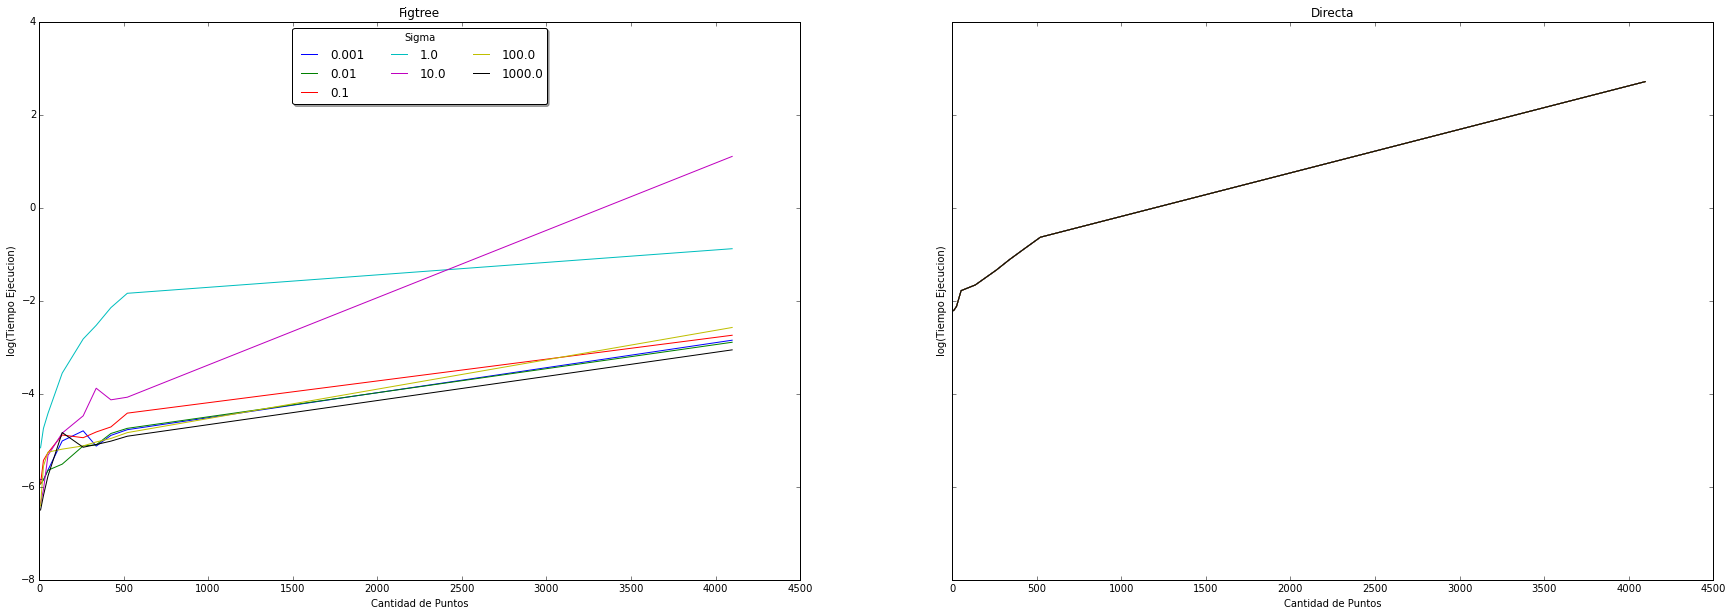

In [13]:
width = 30
height = 10

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(width, height))

plt.title('Tiempos de ejecucion cambiando parametro sigma')
ax1.set_title('Figtree')
ax1.set_xlabel('Cantidad de Puntos')
ax2.set_xlabel('Cantidad de Puntos')

ax1.set_ylabel('log(Tiempo Ejecucion)')
ax2.set_ylabel('log(Tiempo Ejecucion)')

for i in xrange(len(sigmas)):
    ax1.plot(sizes,np.log(times_fast[:,i]), label=str(sigmas[i]))
ax2.set_title('Directa')
for j in xrange(len(sigmas)):
    ax2.plot(sizes,np.log(times_direct[:,i]))
ax1.legend(loc='upper center',ncol=3, fancybox=True, shadow=True, title="Sigma")
plt.show()

## Using very small amount of data (8 points)

- Converges really fast
- The final error printed by shooting method is the difference between the points in the boundary and the starting points integrated using the momentums obtained.
- Uses the defaults values for Scipy.root.optimize (Tolerance = None and Method = hybrd)

In [40]:
#Load dataset size 8
# X0 is a sphere with 8 points
# alpha_sol is random
# X1 is created using X0 and alpha_sol

X0, X1, alpha_sol = data[8]

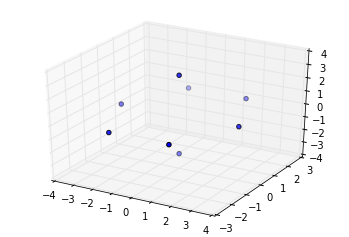

In [41]:
#Plotting Initial positions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X0[:,0],X0[:,1],X0[:,2])
plt.show()

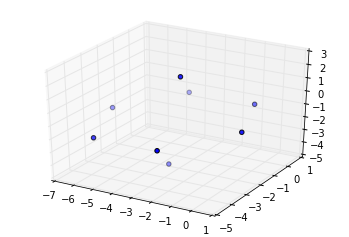

In [42]:
#Plotting Final positions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1[:,0],X1[:,1],X1[:,2])
plt.show()

In [43]:
#Linealizing data
n,m = X0.shape
X_lineal = np.reshape(X0.T, (n*m))
alpha_lineal = np.reshape(alpha_sol.T, (n*m))
vector = np.hstack([X_lineal,alpha_lineal])
t = np.linspace(0,1,100)
#Creating g(y,t) function needed by odeint
g = lambda y,t: f(y,sigma)

#Integrating using odeint, with alpha_sol given
matrix = odeint(g,vector,t)

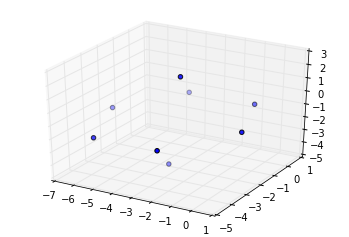

In [44]:
# Plotting the points after integrating to see if odeint works fine
vector = matrix[-1]
positions, momentums = np.split(vector,2)
positions = np.reshape(positions,(3,len(positions)/3)).T
momentums = np.reshape(momentums,(3,len(momentums)/3)).T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0],positions[:,1],positions[:,2])
plt.show()

In [49]:
#Using shooting method to obtain the alpha_sol
alpha0 = np.random.random(X0.shape[0]* X0.shape[1])

alpha = shootingMethod(X0, X1, alpha0, 3, sigma, 'hybr' , None)

Error:  2.10357112403
Error:  2.10357112403
Error:  2.10357112403
Error:  2.10357112528
Error:  2.10357112538
Error:  2.10357112449
Error:  2.10357112481
Error:  2.10357112532
Error:  2.10357112505
Error:  2.10357112459
Error:  2.10357112506
Error:  2.103571125
Error:  2.10357112523
Error:  2.10357112481
Error:  2.10357112443
Error:  2.10357112427
Error:  2.10357112433
Error:  2.10357112509
Error:  2.10357112471
Error:  2.10357112428
Error:  2.10357112471
Error:  2.10357112516
Error:  2.10357112497
Error:  2.10357112429
Error:  2.103571125
Error:  2.10357112507
Error:  2.10357112507
Error:  0.0836996204073
Error:  0.0428597441931
Error:  0.122386324774
Error:  0.0374891617653
Error:  0.0299322631146
Error:  0.0365668421658
Error:  0.0168899169656
Error:  0.00743762610912
Error:  0.00333593783039
Error:  0.0022960897389
Error:  0.00462504290672
Error:  0.000984754068752
Error:  0.000411700847285
Error:  0.000560598703107
Error:  0.000415354443877
Error:  0.00041170074465
Error:  0.00041

In [51]:
alpha_obtenido = alpha.x
print "Diferencia entre alfas", np.linalg.norm(alpha_lineal - alpha_obtenido)/np.linalg.norm(alpha_sol)

Diferencia entre alfas 2.48706741997e-09


In [52]:
#Validating Data
#Linealizing data
n,m = X0.shape
X_lineal = np.reshape(X0.T, (n*m))
vector = np.hstack([X_lineal,alpha_obtenido])
t = np.linspace(0,1,100)
#Creating g(y,t) function needed by odeint
g = lambda y,t: f(y,sigma)

#Integrating using odeint, with alpha_sol given
matrix = odeint(g,vector,t)

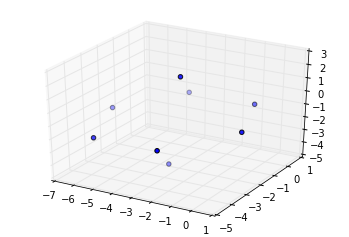

In [53]:
# Plotting the points after integrating to see if odeint works fine
vector = matrix[-1]
positions, momentums = np.split(vector,2)
positions = np.reshape(positions,(3,len(positions)/3)).T
momentums = np.reshape(momentums,(3,len(momentums)/3)).T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0],positions[:,1],positions[:,2])
plt.show()

## Using Bigger Data (52 points)
- Converges slowly but steady, with a bigger amount of points the algorithm must run days.

**Using Krylov method (in Scipy.optimize.root documentation says it is useful for large-scale problems)**

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.root.html

In [34]:
#Load dataset size 52
# X0 is a sphere with 52 points
# alpha_sol is random
# X1 is created using X0 and alpha_sol

X0, X1, alpha_sol = data[52]

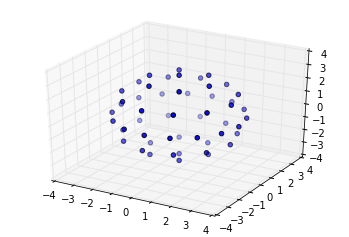

In [35]:
#Plotting Initial positions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X0[:,0],X0[:,1],X0[:,2])
plt.show()

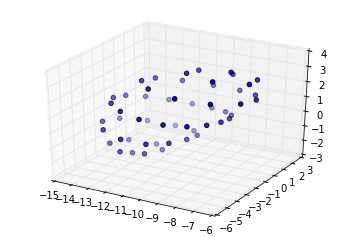

In [36]:
#Plotting Final positions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1[:,0],X1[:,1],X1[:,2])
plt.show()

In [37]:
#Linealizing data
n,m = X0.shape
X_lineal = np.reshape(X0.T, (n*m))
alpha_lineal = np.reshape(alpha_sol.T, (n*m))
vector = np.hstack([X_lineal,alpha_lineal])
t = np.linspace(0,1,100)
#Creating g(y,t) function needed by odeint
g = lambda y,t: f(y,sigma)

#Integrating using odeint, with alpha_sol given
matrix = odeint(g,vector,t)

In [38]:
#Solving the BVP
#Using shooting method to obtain the alpha_sol
alpha0 = np.random.random(X0.shape[0]* X0.shape[1])

tol = 1e-3
alpha = shootingMethod(X0, X1, alpha0, 3, sigma, 'krylov', tol)
#It converges very slowly (3 hours and counting with tolerance 1e-3)

KeyboardInterrupt: 

In [ ]:
alpha_obtenido = alpha.x
print "Diferencia entre alfas", np.linalg.norm(alpha_lineal - alpha_obtenido)/np.linalg.norm(alpha_sol)